# Genetic Variant Divider Pipeline
This notebook processes VCF files for two groups of samples, identifying and filtering common SNPs between "control" and "test" samples.

# Creator: Dr. Nidhi Sukhija

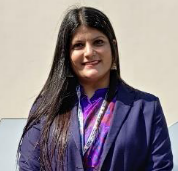

Scientist-B

Central Tasar Research and Training Institute,

Ministry of Textiles, Government of India

Mail ID: nidhisukhija5@gmail.com

[Google Scholar](https://scholar.google.com/citations?user=l85VhKQAAAAJ&hl=en);    [ResearchGate](https://www.researchgate.net/profile/Nidhi-Sukhija/research);    [Website](https://ctrti.res.in/scientist-profile/)

#Instructions for Use

**Prepare Your Files:**

Rename your VCF files to:

Group 1: control_1.vcf.gz through control_6.vcf.gz
Group 2: test_1.vcf.gz through test_6.vcf.gz

**Run the Notebook:**

Execute each cell in order (use Shift+Enter or the play button)
When prompted, upload your renamed VCF files
Wait for each step to complete before moving to the next

**What This Pipeline Does:**

Indexes all VCF files
Merges files into groups
Identifies common SNPs between groups
Filters out common SNPs
Generates statistics and counts
Creates filtered VCF files

**Output Files:**

All results will be in the downloaded vcf_analysis_results.tar.gz

---

Files include:

Filtered VCF files
SNP counts and statistics
Log files with processing details
Lists of common SNPs

**Notes:**

Make sure your VCF files are properly formatted and compressed (.vcf.gz)
All files should be indexed before uploading
Processing time depends on file size and number of SNPs

# 1. Setup and Dependencies

In [ ]:
!apt-get install bcftools
!pip install pandas

# 2. File Upload Section

In [ ]:
from google.colab import files
import os

def upload_files():
    """
    Upload VCF files for processing
    Group 1: control_1.vcf.gz through control_6.vcf.gz
    Group 2: test_1.vcf.gz through test_6.vcf.gz
    """
    !mkdir -p /content/vcf_files

    print("Please upload Group 1 files (control_1.vcf.gz through control_6.vcf.gz)")
    uploaded_control = files.upload()

    print("\nPlease upload Group 2 files (test_1.vcf.gz through test_6.vcf.gz)")
    uploaded_test = files.upload()

    # Move files to vcf_files directory
    !mv *.vcf.gz /content/vcf_files/

# Run this cell to upload your files
upload_files()

# 3. Define Variables and Functions

In [ ]:
import subprocess
import gzip

# Define the directories
VCF_DIR = "/content/vcf_files"
OUTPUT_DIR = "/content/output"

# Create output directory
!mkdir -p {OUTPUT_DIR}

# Define output files
file_paths = {
    'control': {
        'merged_good': f"{VCF_DIR}/control_group1.vcf.gz",
        'merged_bad': f"{VCF_DIR}/control_group2.vcf.gz",
        'good_snps': f"{OUTPUT_DIR}/snps_group1_control.txt",
        'bad_snps': f"{OUTPUT_DIR}/snps_group2_control.txt",
        'common_snps': f"{OUTPUT_DIR}/common_snps_control.txt",
        'header': f"{OUTPUT_DIR}/header_control.txt",
        'filtered_body': f"{OUTPUT_DIR}/filtered_body_control.txt",
        'filtered_vcf': f"{OUTPUT_DIR}/filtered_control.vcf.gz",
        'unzipped_vcf': f"{OUTPUT_DIR}/filtered_control.vcf",
        'snp_count': f"{OUTPUT_DIR}/snp_count_control.txt",
        'common_snps_count': f"{OUTPUT_DIR}/common_snps_count_control.txt",
        'log': f"{OUTPUT_DIR}/processing_control.log"
    },
    'test': {
        'merged_good': f"{VCF_DIR}/test_group1.vcf.gz",
        'merged_bad': f"{VCF_DIR}/test_group2.vcf.gz",
        'good_snps': f"{OUTPUT_DIR}/snps_group1_test.txt",
        'bad_snps': f"{OUTPUT_DIR}/snps_group2_test.txt",
        'common_snps': f"{OUTPUT_DIR}/common_snps_test.txt",
        'header': f"{OUTPUT_DIR}/header_test.txt",
        'filtered_body': f"{OUTPUT_DIR}/filtered_body_test.txt",
        'filtered_vcf': f"{OUTPUT_DIR}/filtered_test.vcf.gz",
        'unzipped_vcf': f"{OUTPUT_DIR}/filtered_test.vcf",
        'snp_count': f"{OUTPUT_DIR}/snp_count_test.txt",
        'common_snps_count': f"{OUTPUT_DIR}/common_snps_count_test.txt",
        'log': f"{OUTPUT_DIR}/processing_test.log"
    }
}

# 4. Index VCF Files

In [ ]:
def index_vcf_files(dataset):
    """Index VCF files using bcftools"""
    print(f"Indexing {dataset} VCF files...")
    for i in range(1, 7):
        vcf_file = f"{VCF_DIR}/{dataset}_{i}.vcf.gz"
        subprocess.run(['bcftools', 'index', '-t', vcf_file, '-f'])

# Run indexing
index_vcf_files('control')
index_vcf_files('test')

# 5. Merge VCF Files

In [ ]:
def merge_vcf_files(dataset):
    """Merge VCF files for group 1 and group 2 samples"""
    print(f"Merging {dataset} files...")

    # Merge group 1 files (1-3)
    group1_files = [f"{VCF_DIR}/{dataset}_{i}.vcf.gz" for i in range(1, 4)]
    subprocess.run(['bcftools', 'merge', '-O', 'z', '-o',
                   file_paths[dataset]['merged_good']] + group1_files)

    # Merge group 2 files (4-6)
    group2_files = [f"{VCF_DIR}/{dataset}_{i}.vcf.gz" for i in range(4, 7)]
    subprocess.run(['bcftools', 'merge', '-O', 'z', '-o',
                   file_paths[dataset]['merged_bad']] + group2_files)

    # Index merged files
    subprocess.run(['bcftools', 'index', '-t', file_paths[dataset]['merged_good']])
    subprocess.run(['bcftools', 'index', '-t', file_paths[dataset]['merged_bad']])

# Run merging
merge_vcf_files('control')
merge_vcf_files('test')

# 6. Process VCF Files

In [ ]:
def process_vcf(dataset):
    """Process VCF files to identify and filter common SNPs"""
    paths = file_paths[dataset]

    # Extract SNP positions
    print(f"Extracting SNP positions for {dataset}...")

    # From group 1 VCF
    with gzip.open(paths['merged_good'], 'rt') as f:
        group1_snps = set()
        for line in f:
            if not line.startswith('#'):
                cols = line.split('\t')
                group1_snps.add(f"{cols[0]}:{cols[1]}")

    with open(paths['good_snps'], 'w') as f:
        for snp in sorted(group1_snps):
            f.write(f"{snp}\n")

    # From group 2 VCF
    with gzip.open(paths['merged_bad'], 'rt') as f:
        group2_snps = set()
        for line in f:
            if not line.startswith('#'):
                cols = line.split('\t')
                group2_snps.add(f"{cols[0]}:{cols[1]}")

    with open(paths['bad_snps'], 'w') as f:
        for snp in sorted(group2_snps):
            f.write(f"{snp}\n")

    # Find common SNPs
    common_snps = group1_snps.intersection(group2_snps)
    with open(paths['common_snps'], 'w') as f:
        for snp in sorted(common_snps):
            f.write(f"{snp}\n")

    # Write counts
    with open(paths['common_snps_count'], 'w') as f:
        f.write(f"{dataset} Common SNPs: {len(common_snps)} SNPs\n")

    with open(paths['snp_count'], 'w') as f:
        f.write(f"{dataset} Group 1 SNPs: {len(group1_snps)} SNPs\n")
        f.write(f"{dataset} Group 2 SNPs: {len(group2_snps)} SNPs\n")

    # Extract header and filter common SNPs
    with gzip.open(paths['merged_good'], 'rt') as f:
        with open(paths['header'], 'w') as header_f:
            for line in f:
                if line.startswith('#'):
                    header_f.write(line)
                else:
                    break

    # Filter and write final VCF
    with gzip.open(paths['merged_good'], 'rt') as f:
        with gzip.open(paths['filtered_vcf'], 'wt') as out_f:
            for line in f:
                if line.startswith('#'):
                    out_f.write(line)
                else:
                    cols = line.split('\t')
                    snp_id = f"{cols[0]}:{cols[1]}"
                    if snp_id not in common_snps:
                        out_f.write(line)

    # Create unzipped version
    subprocess.run(['gunzip', '-c', paths['filtered_vcf']],
                  stdout=open(paths['unzipped_vcf'], 'w'))

# Process both datasets
process_vcf('control')
process_vcf('test')

# 7. Download Results

In [ ]:
def download_results():
    """Download processed files"""
    print("Compressing results...")
    !cd {OUTPUT_DIR} && tar -czf vcf_analysis_results.tar.gz *

    print("\nDownloading results...")
    files.download(f"{OUTPUT_DIR}/vcf_analysis_results.tar.gz")

# Run this cell to download your results
download_results()

# For queries:
write to nidhisukhija5@gmail.com